# Base

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [84]:
# Load the updated dataset
df = pd.read_csv('./bananaindex_with_categories.csv')

# One-hot encode the 'Food Category'
df_encoded = pd.get_dummies(df, columns=['Food Category'], drop_first=True)

# Extract the original 'Food Category' for visualization
df['Food Category'] = df['Food Category']
food_names = df['entity']

# Select features for scaling
features = [
    "land_use_kg",
    "land_use_1000kcal",
    "Land use per 100 grams of protein"
]
X = df_encoded[features].values

# Separate the target values
y = df_encoded[
    [
        "Bananas index (kg)",
        "Bananas index (1000 kcalories)",
        "Bananas index (100g protein)",
    ]
].values

# Impute missing values and scale the features
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the dataset
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X_scaled, y, food_names, test_size=0.2, random_state=42
)
categories_train, categories_test = train_test_split(df['Food Category'], test_size=0.2, random_state=42)



## Average Banana Index's histograms

C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2108049021.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (kg)', palette="Set3", ci=None)  # ci=None removes the confidence interval
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2108049021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (kg)', palette="Set3", ci=None)  # ci=None removes the confidence interval


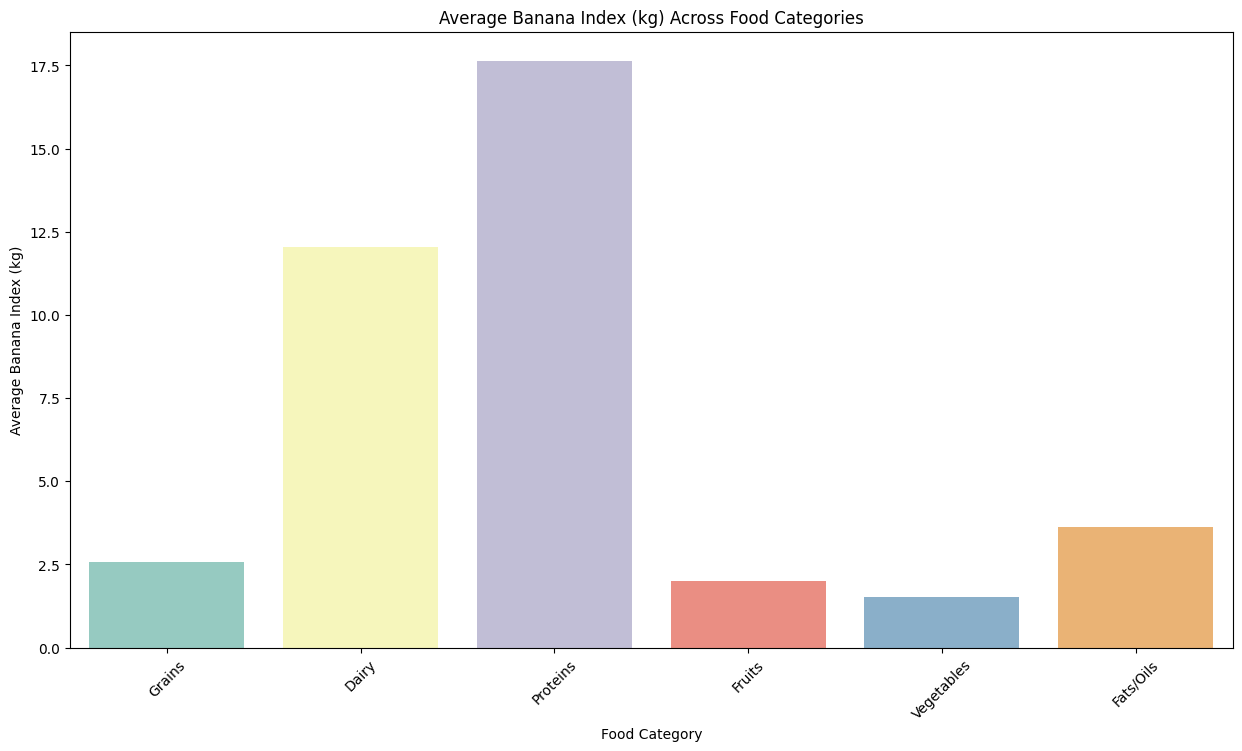

In [85]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Food Category', y='Bananas index (kg)', palette="Set3", ci=None)  # ci=None removes the confidence interval
plt.title('Average Banana Index (kg) Across Food Categories')
plt.xlabel('Food Category')
plt.xticks(rotation=45)
plt.ylabel('Average Banana Index (kg)')
plt.show()

C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (1000 kcalories)', palette="Set3", ci=None)
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (1000 kcalories)', palette="Set3", ci=None)
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Food Category', y='Bananas index (1000 kcalories)', palette="Set2")


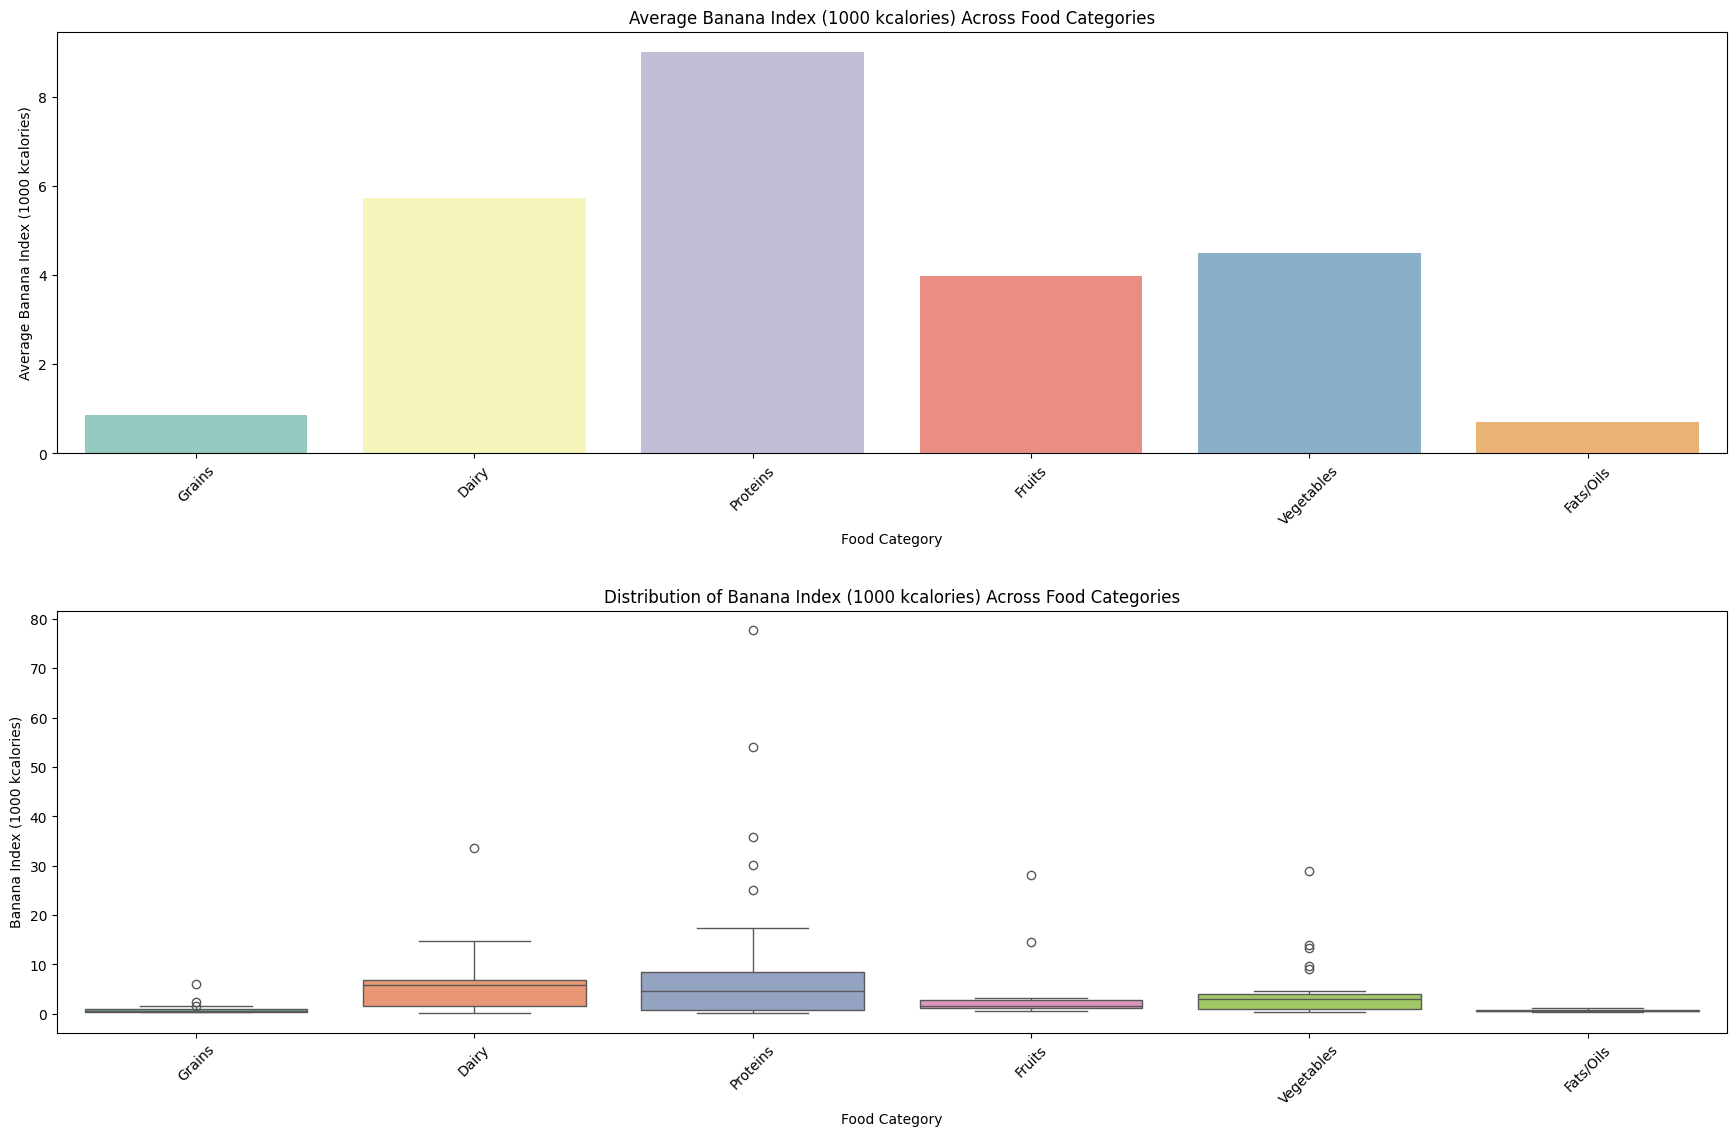

C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (100g protein)', palette="Set3", ci=None)
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Food Category', y='Bananas index (100g protein)', palette="Set3", ci=None)
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\2397116439.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Food Category', y='Bananas index (100g protein)', palette="Set2")


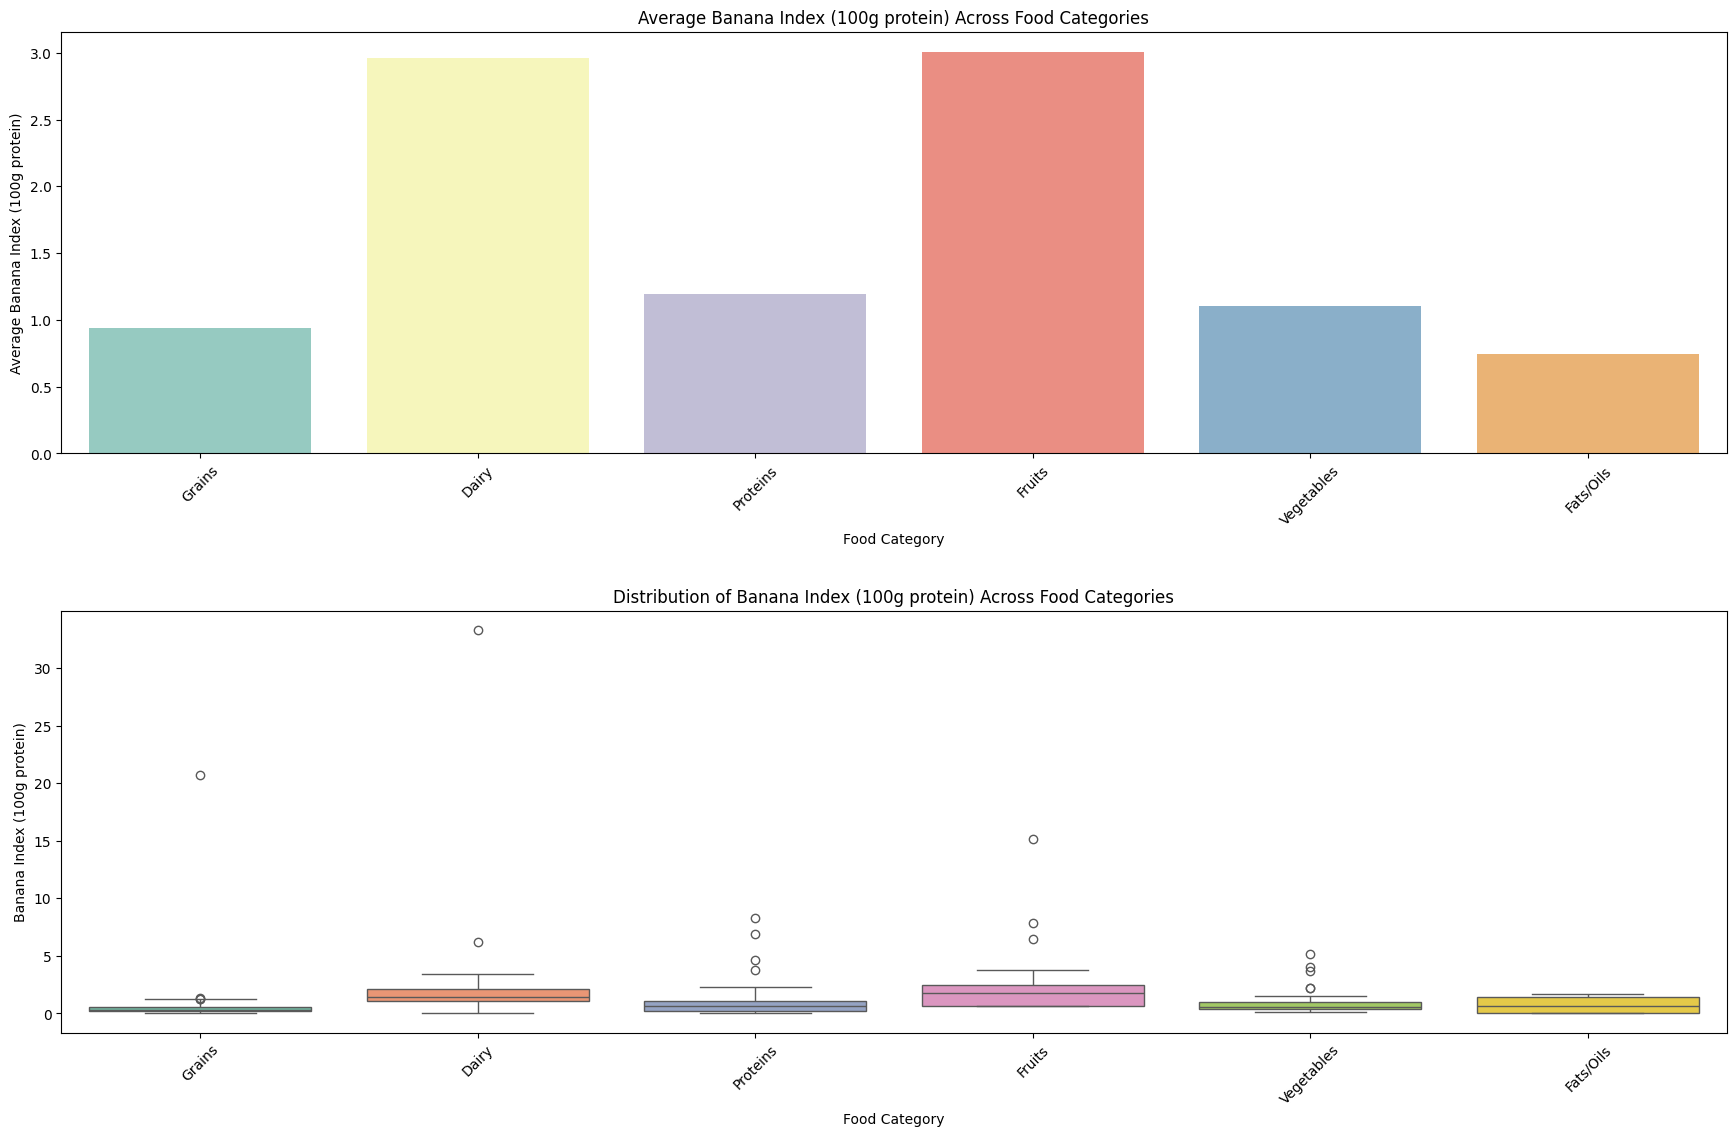

In [86]:
# Set a larger figure size for subplots
plt.figure(figsize=(18, 12))

# Create a bar plot for 'Bananas index (1000 kcalories)'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
sns.barplot(data=df, x='Food Category', y='Bananas index (1000 kcalories)', palette="Set3", ci=None)
plt.title('Average Banana Index (1000 kcalories) Across Food Categories')
plt.xlabel('Food Category')
plt.xticks(rotation=45)
plt.ylabel('Average Banana Index (1000 kcalories)')

# Create a box plot for 'Bananas index (1000 kcalories)' to show the distribution
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
sns.boxplot(data=df, x='Food Category', y='Bananas index (1000 kcalories)', palette="Set2")
plt.title('Distribution of Banana Index (1000 kcalories) Across Food Categories')
plt.xlabel('Food Category')
plt.xticks(rotation=45)
plt.ylabel('Banana Index (1000 kcalories)')

# Adjusting space between the plots to prevent label overlap
plt.tight_layout(pad=3.0)

# Show combined plot
plt.show()

# Repeat the process for 'Bananas index (100g protein)'
plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
sns.barplot(data=df, x='Food Category', y='Bananas index (100g protein)', palette="Set3", ci=None)
plt.title('Average Banana Index (100g protein) Across Food Categories')
plt.xlabel('Food Category')
plt.xticks(rotation=45)
plt.ylabel('Average Banana Index (100g protein)')

plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='Food Category', y='Bananas index (100g protein)', palette="Set2")
plt.title('Distribution of Banana Index (100g protein) Across Food Categories')
plt.xlabel('Food Category')
plt.xticks(rotation=45)
plt.ylabel('Banana Index (100g protein)')

plt.tight_layout(pad=3.0)

plt.show()

# Predictive Models

In [87]:
from model_funcs import model_wrap, evaluate
import ModelComparison
from importlib import reload

reload(ModelComparison)
model_output = ModelComparison.ModelComparison()

## Linear Regression

R-squared for the 1 target: 0.9562939950118975
R-squared for the 2 target: 0.8703743810047955
R-squared for the 3 target: 0.5889284791671455


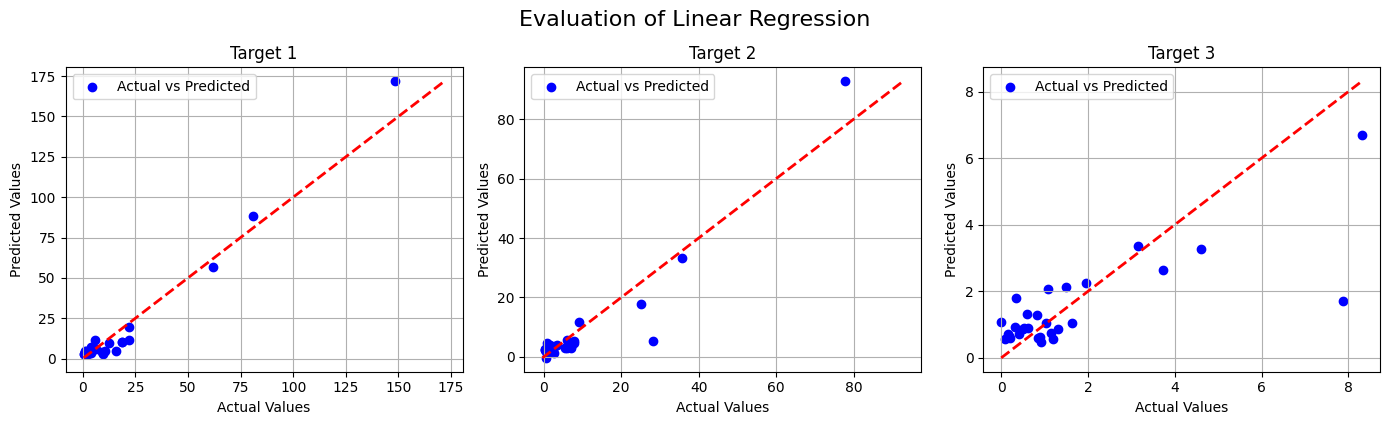

In [88]:
base_model = LinearRegression()
y_pred = model_wrap(base_model, X_train, y_train, X_test)
evaluate(y_test, y_pred, "Linear Regression")
model_output.add_model_results('Linear Regression', names_test, y_test, y_pred)

## Random Forest Regression Model

R-squared for the 1 target: 0.8035144522737878
R-squared for the 2 target: 0.7623468130491813
R-squared for the 3 target: 0.5997732737739653


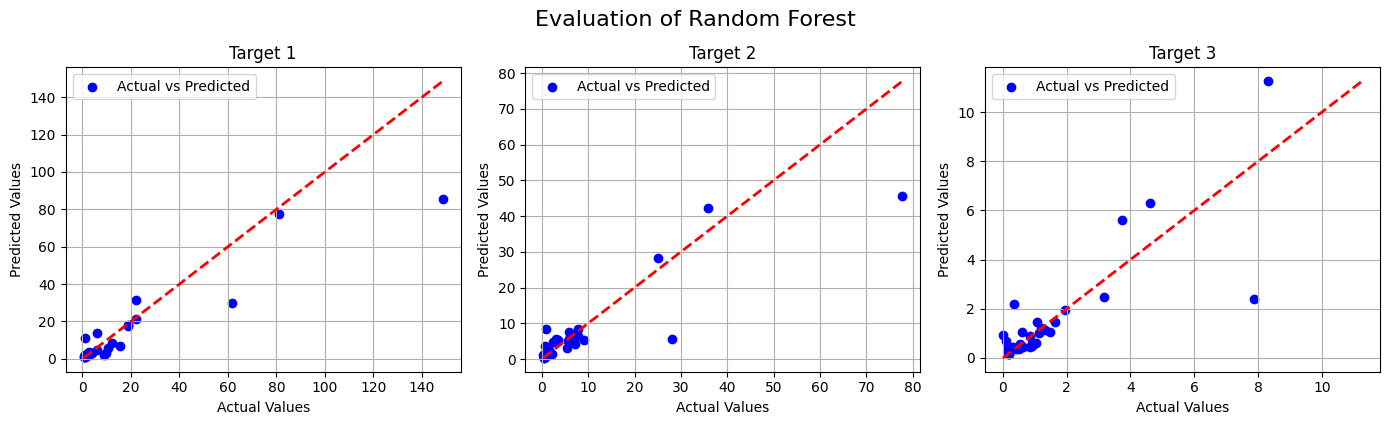

In [89]:
from sklearn.ensemble import RandomForestRegressor

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
y_pred = model_wrap(rf_model, X_train, y_train, X_test)
evaluate(y_test, y_pred, 'Random Forest')
model_output.add_model_results('Random Forest', names_test, y_test, y_pred)

## Grid Search Model

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from grid search:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
R-squared for the 1 target: 0.7780485654633164
R-squared for the 2 target: 0.6683468579360282
R-squared for the 3 target: 0.6287126454686363


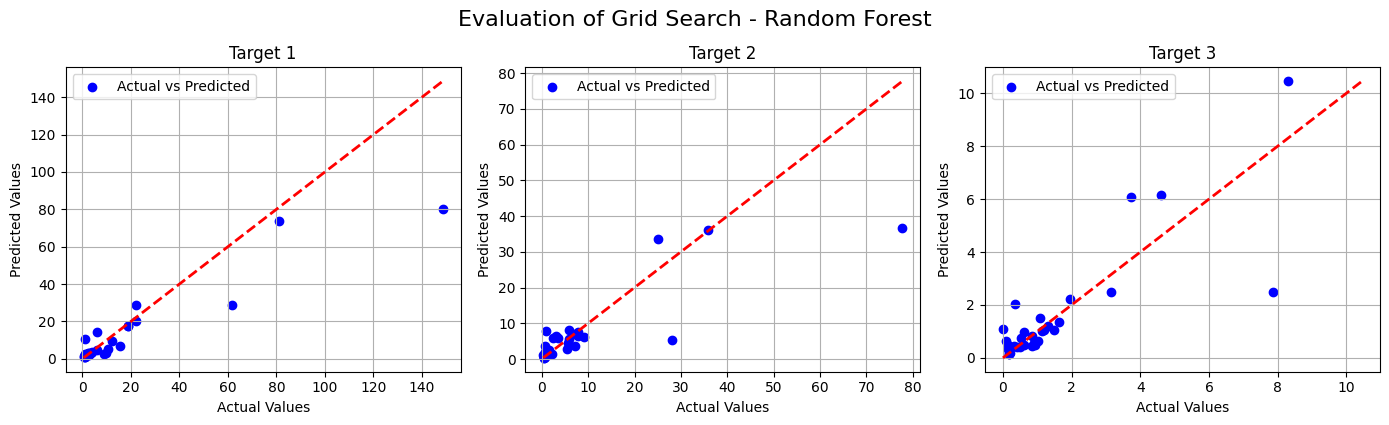

In [90]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

# Initialize the grid search model
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Number of folds for cross-validation
    verbose=2,  # Controls the verbosity: the higher, the more messages
    n_jobs=-1,
)  # Number of jobs to run in parallel

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and associated model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best parameters from grid search: ", best_params)

y_pred = model_wrap(best_rf_model, X_train, y_train, X_test)
evaluate(y_test, y_pred, 'Grid Search - Random Forest')
model_output.add_model_results('Grid Search - Random Forest', names_test, y_test, y_pred)

## Pipe Line 

R-squared for the 1 target: 0.7780485654633164
R-squared for the 2 target: 0.6683468579360282
R-squared for the 3 target: 0.6287126454686363


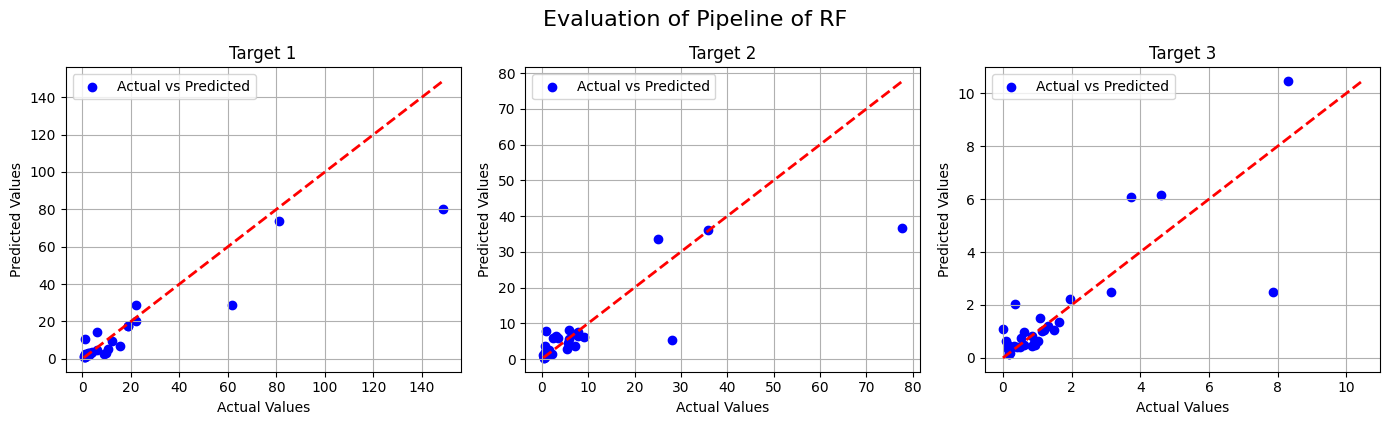

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# A pipeline with StandardScaler and the best RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params, random_state=42))  # Using best_params found from grid search
])

y_pred = model_wrap(pipeline, X_train, y_train, X_test)
evaluate(y_test, y_pred, 'Pipeline of RF')
model_output.add_model_results('Pipeline of RF', names_test, y_test, y_pred)

### Neural Network

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 82.0776 - val_loss: 107.0269
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 81.0279 - val_loss: 106.3011
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 80.9283 - val_loss: 105.5843
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 79.0791 - val_loss: 104.8403
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 77.0778 - val_loss: 104.0001
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 76.5996 - val_loss: 103.1148
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 73.0315 - val_loss: 102.1154
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 72.9622 - val_loss: 101.0801
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 70.2590 - val_loss: 99.9169
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 69.6658 - val_loss: 98.6822
Epoch 11/

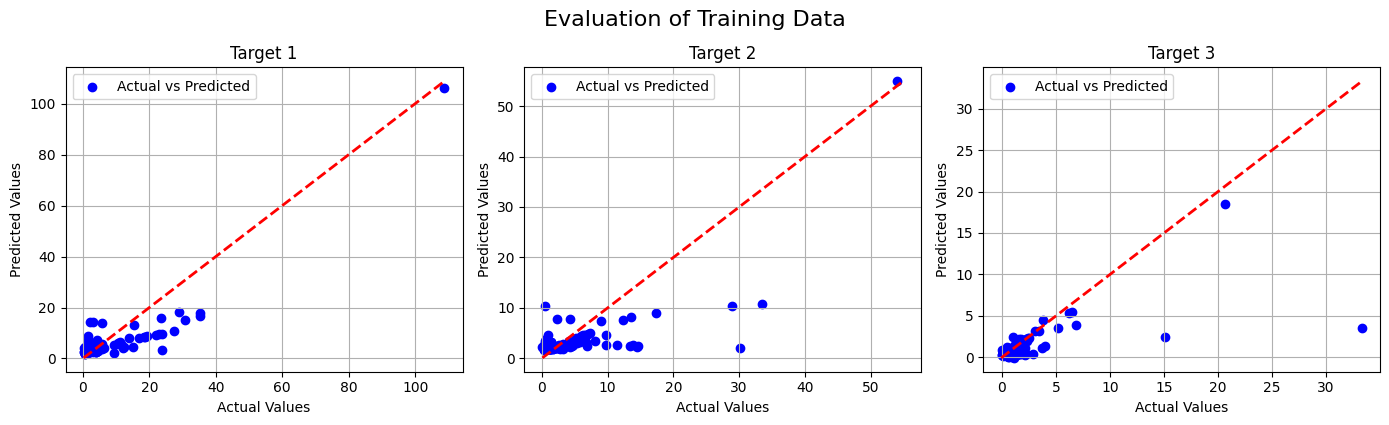

R-squared for the 1 target: 0.9621290746783474
R-squared for the 2 target: 0.8905474803885185
R-squared for the 3 target: 0.3991684576043597


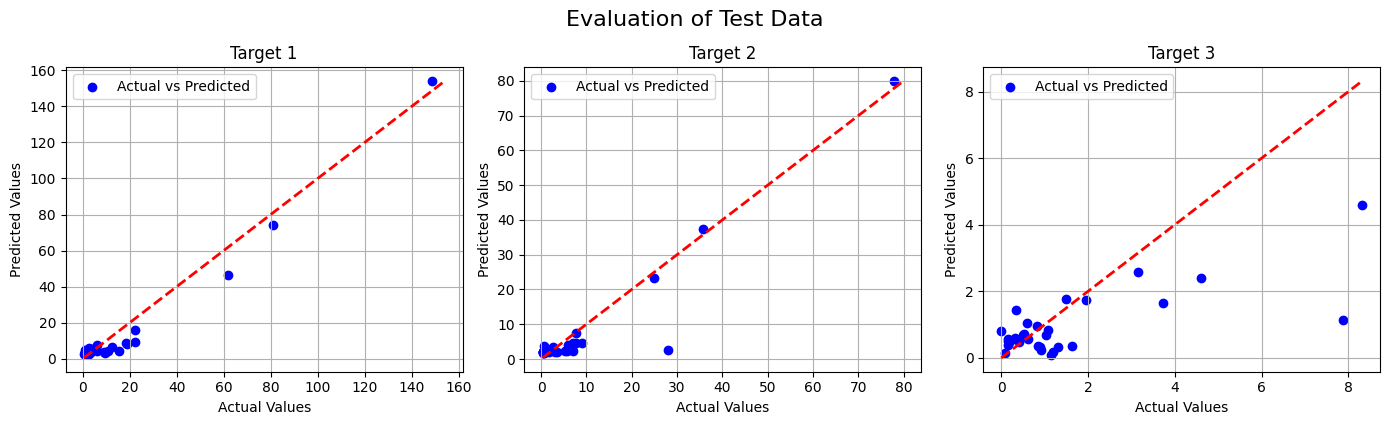

In [92]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))  # No activation for a regression problem

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with a validation split
history = model.fit(
    X_train, y_train,
    epochs=50,  # More epochs with early stopping
    batch_size=32,
    validation_split=0.2,  # Use part of the training data for validation
    callbacks=[early_stopping]
)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
evaluate(y_train, y_pred_train, 'Training Data')
evaluate(y_test, y_pred_test, 'Test Data')
model_output.add_model_results('Neural Network', names_test, y_test, y_pred_test)

### Bayesian Optimized NN

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

1/1 [==============================] - 0s 43ms/step  

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 41ms/step                            

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 55ms/step                            

1/1 [==============================] - 0s 46ms/step                            

1/1 [==============================] - 0s 47ms/step                           

1/1 [==============================] - 0s 44ms/step                           

1/1 [==============================] - 0s 42ms/step                           

1/1 [==============================] - 0s 48ms/step                            

1/1 [==============================] - 0s 53ms/step                             

1/1 [==============================] - 0s 47ms/step                             

1/1 [==============================] - 0s 45ms/step    

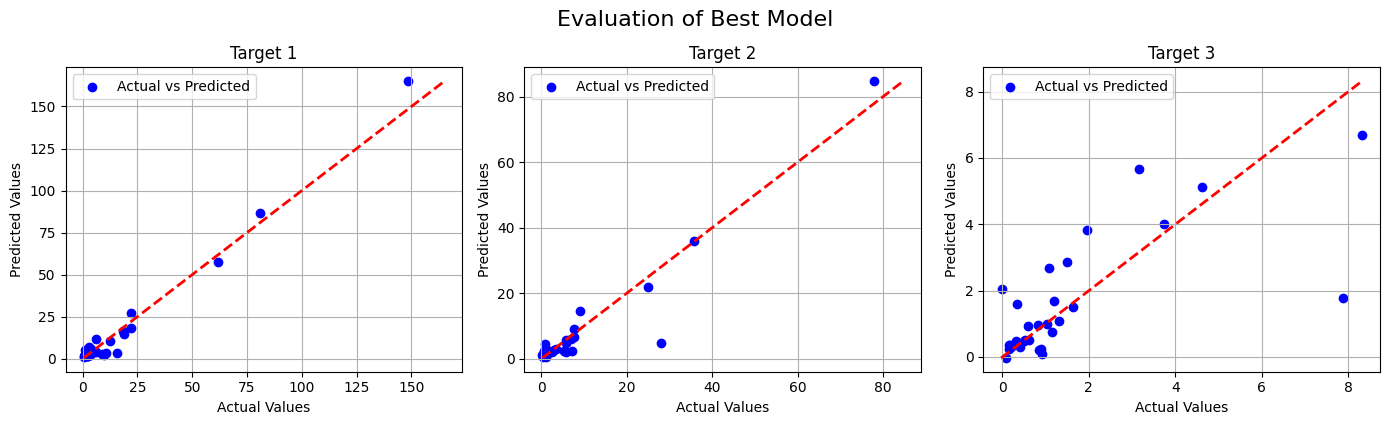

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

space = {
    'units1': hp.choice('units1', [32, 64, 128, 256]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'units2': hp.choice('units2', [32, 64, 128]),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop'])
}

def build_model(units1, dropout1, units2, dropout2, optimizer):
    model = tf.keras.models.Sequential([
        Dense(units1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout1),
        Dense(units2, activation='relu'),
        Dropout(dropout2),
        Dense(y_train.shape[1])  # Output layer with no activation for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define the objective function for hyperopt
def objective(hyperparams):
    # Extract batch_size and remove from hyperparams as it's not needed for build_model
    batch_size = hyperparams.pop('batch_size')
    model = build_model(**hyperparams)
    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=100, verbose=0)
    
    # Add batch_size back to hyperparams for any further use
    hyperparams['batch_size'] = batch_size
    
    y_pred_test = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    return {'loss': mse, 'status': STATUS_OK}

# Run the hyperparameter optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Correctly extract the best hyperparameters, including batch_size
best_units1 = [32, 64, 128, 256][best_hyperparams['units1']]
best_dropout1 = best_hyperparams['dropout1']
best_units2 = [32, 64, 128][best_hyperparams['units2']]
best_dropout2 = best_hyperparams['dropout2']
best_batch_size = [16, 32, 64][best_hyperparams['batch_size']]
best_optimizer = ['adam', 'rmsprop'][best_hyperparams['optimizer']]

# Re-train the model with the best hyperparameters
best_model = build_model(best_units1, best_dropout1, best_units2, best_dropout2, best_optimizer)
best_model.fit(X_train_scaled, y_train, batch_size=best_batch_size, epochs=100, verbose=0)

# Predict with the best model
y_pred_test = best_model.predict(X_test_scaled)

# Evaluate the best model
evaluate(y_test, y_pred_test, model_name="Best Model")
model_output.add_model_results('Optimized Neural Network', names_test, y_test, y_pred_test)


In [94]:
model_output.export_to_excel('./IndexResults.xlsx')

## Feature Importance Visualization for RandomForestRegressor

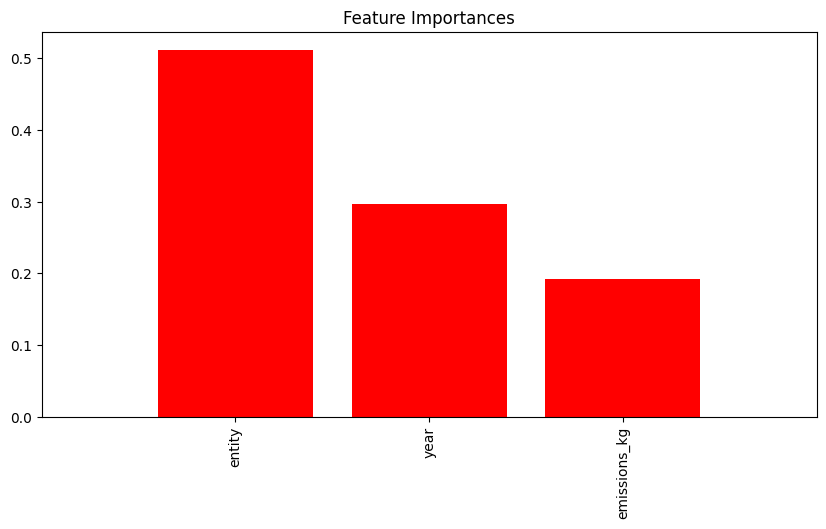

In [95]:
# Feature importance for RandomForestRegressor
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.columns[:len(importances)]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Visualizing GridSearchCV Results

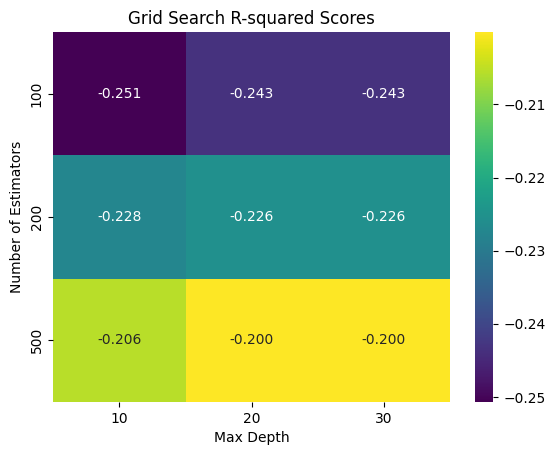

In [96]:
import seaborn as sns

# Heatmap for GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_n_estimators',
                                  columns='param_max_depth',
                                  values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title("Grid Search R-squared Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

## Residual Plot for LinearRegression

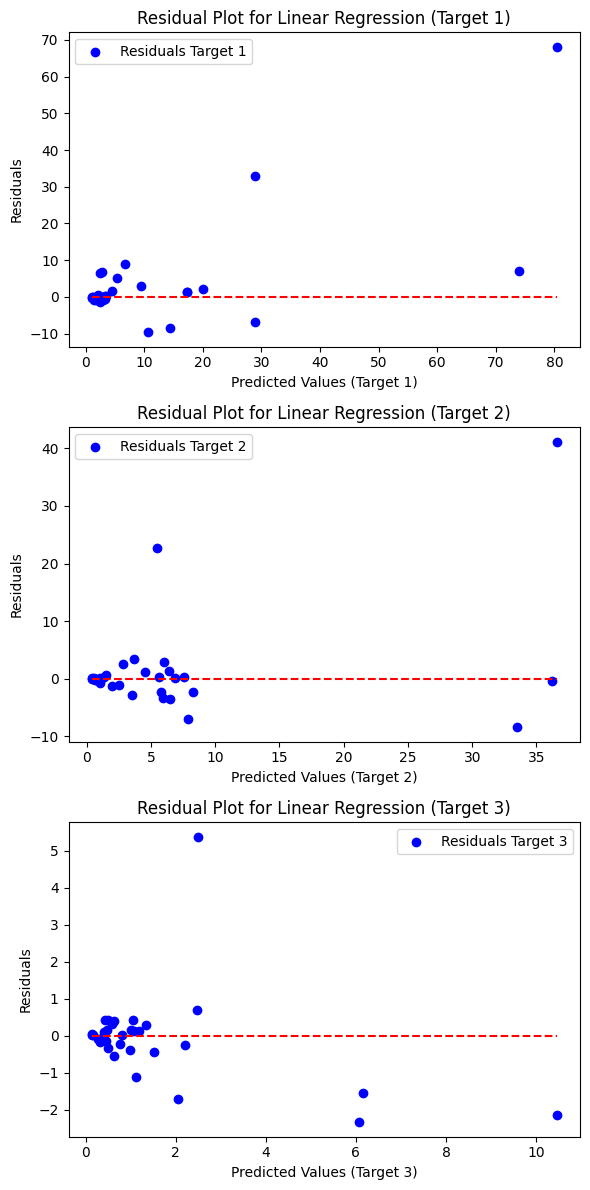

In [97]:
# Number of targets
n_targets = y_test.shape[1]

# Create a figure with a subplot for each target
fig, axes = plt.subplots(n_targets, 1, figsize=(6, 4 * n_targets))

# Loop through each target for residual plots
for i in range(n_targets):
    residuals = y_test[:, i] - y_pred[:, i]
    axis = axes[i] if n_targets > 1 else axes
    axis.scatter(y_pred[:, i], residuals, color='blue', label=f'Residuals Target {i+1}')
    axis.hlines(0, np.min(y_pred[:, i]), np.max(y_pred[:, i]), colors='red', linestyles='--')
    axis.set_xlabel(f'Predicted Values (Target {i+1})')
    axis.set_ylabel('Residuals')
    axis.set_title(f'Residual Plot for Linear Regression (Target {i+1})')
    axis.legend()

plt.tight_layout()
plt.show()

# Nutritional Footprint Index

C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\825117577.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted.head(top_n), x='NFI', y='entity', palette='viridis')


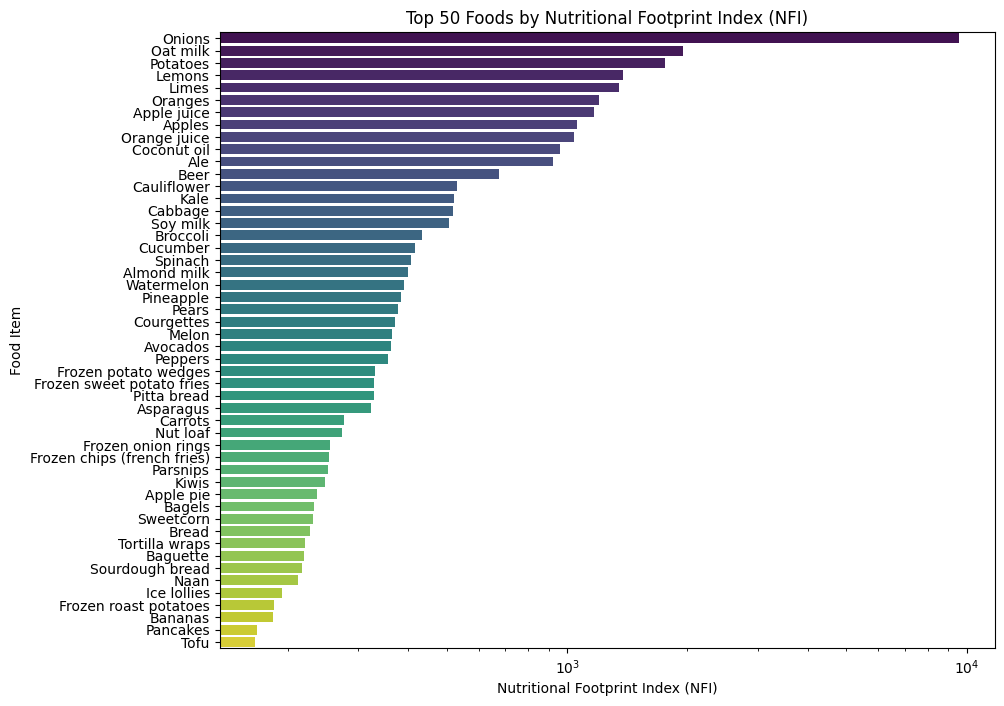

In [98]:
# Function to compute Nutritional Footprint Index (NFI)
def calculate_nfi(df):
    env_cost = (df['emissions_kg'] + df['land_use_kg']) / 2
    nutritional_value = (df['emissions_1000kcal'] + df['emissions_100g_protein'] + df['emissions_100g_fat']) / 3
    normalized_env_cost = (env_cost - env_cost.min()) / (env_cost.max() - env_cost.min())
    normalized_nutri_value = 1 - ((nutritional_value - nutritional_value.min()) / (nutritional_value.max() - nutritional_value.min()))
    df['NFI'] = normalized_nutri_value / (normalized_env_cost + 0.0001)  # Avoid division by zero
    return df

# Calculate NFI and then sort the DataFrame based on NFI
df = calculate_nfi(df)
df_sorted = df.sort_values(by='NFI', ascending=False)

# Visualize the top N food items based on NFI
top_n = 50
plt.figure(figsize=(10, 8))
sns.barplot(data=df_sorted.head(top_n), x='NFI', y='entity', palette='viridis')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (NFI)
plt.title('Top 50 Foods by Nutritional Footprint Index (NFI)')
plt.xlabel('Nutritional Footprint Index (NFI)')
plt.ylabel('Food Item')
plt.show()

   - A higher NFI value indicates that the food item provides more nutrition per environmental cost unit. In other words, it's a more 'eco-efficient' or 'sustainable' choice from the viewpoint of emissions and land use for the nutritional content it provides.
   - The NFI is attempting to encapsulate the trade-off between the environmental impact of producing the food and the nutritional benefits it offers. 

C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\755473265.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_nfi_by_category, x='NFI', y='Food Category', palette='viridis', orient='h')


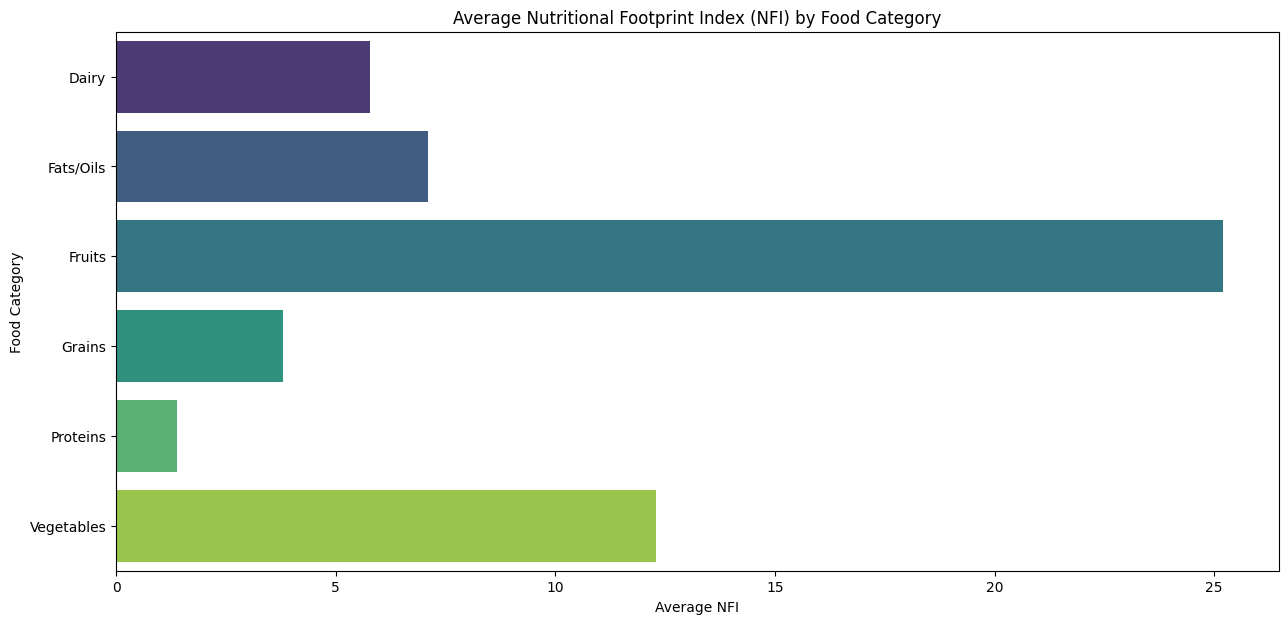

In [99]:
def calculate_nfi_attributes(row, min_env_cost, max_env_cost, min_nutritional_value, max_nutritional_value):
    env_cost = (row['emissions_kg'] + row['land_use_kg']) / 2
    nutritional_value = (row['emissions_1000kcal'] + row['emissions_100g_protein'] + row['emissions_100g_fat']) / 3
    normalized_env_cost = (env_cost - min_env_cost) / (max_env_cost - min_env_cost)
    normalized_nutri_value = (nutritional_value - min_nutritional_value) / (max_nutritional_value - min_nutritional_value)
    nfi = normalized_nutri_value / (normalized_env_cost + 0.0001)  # Avoid division by zero
    
    return nfi 

# Find the global min and max for normalization across the entire dataset
min_env_cost = df[['emissions_kg', 'land_use_kg']].min().min()
max_env_cost = df[['emissions_kg', 'land_use_kg']].max().max()
min_nutritional_value = df[['emissions_1000kcal', 'emissions_100g_protein', 'emissions_100g_fat']].min().min()
max_nutritional_value = df[['emissions_1000kcal', 'emissions_100g_protein', 'emissions_100g_fat']].max().max()

# Apply the calculate_nfi function to each row
# Now we pass the additional arguments for min and max values directly to the function
df['NFI'] = df.apply(calculate_nfi_attributes, args=(min_env_cost, max_env_cost, min_nutritional_value, max_nutritional_value), axis=1)

# Group by 'Food Category' and calculate the average NFI for each category
average_nfi_by_category = df.groupby('Food Category')['NFI'].mean().reset_index()

# Display the result
average_nfi_by_category

# Assuming you want to visualize this information
# We'll plot a bar chart showing the average NFI for each food category
plt.figure(figsize=(15, 7))
sns.barplot(data=average_nfi_by_category, x='NFI', y='Food Category', palette='viridis', orient='h')
plt.title('Average Nutritional Footprint Index (NFI) by Food Category')
plt.xlabel('Average NFI')
plt.ylabel('Food Category')
plt.show()


C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\4150405139.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_df, x='NFI', y='entity', palette='icefire')
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\4150405139.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_df, x='NFI', y='entity', palette='icefire')
C:\Users\deteb\AppData\Local\Temp\ipykernel_11380\4150405139.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_df, x='NFI', y='entity', palette='icefire')
C:\Users\deteb\AppData\Local\Te

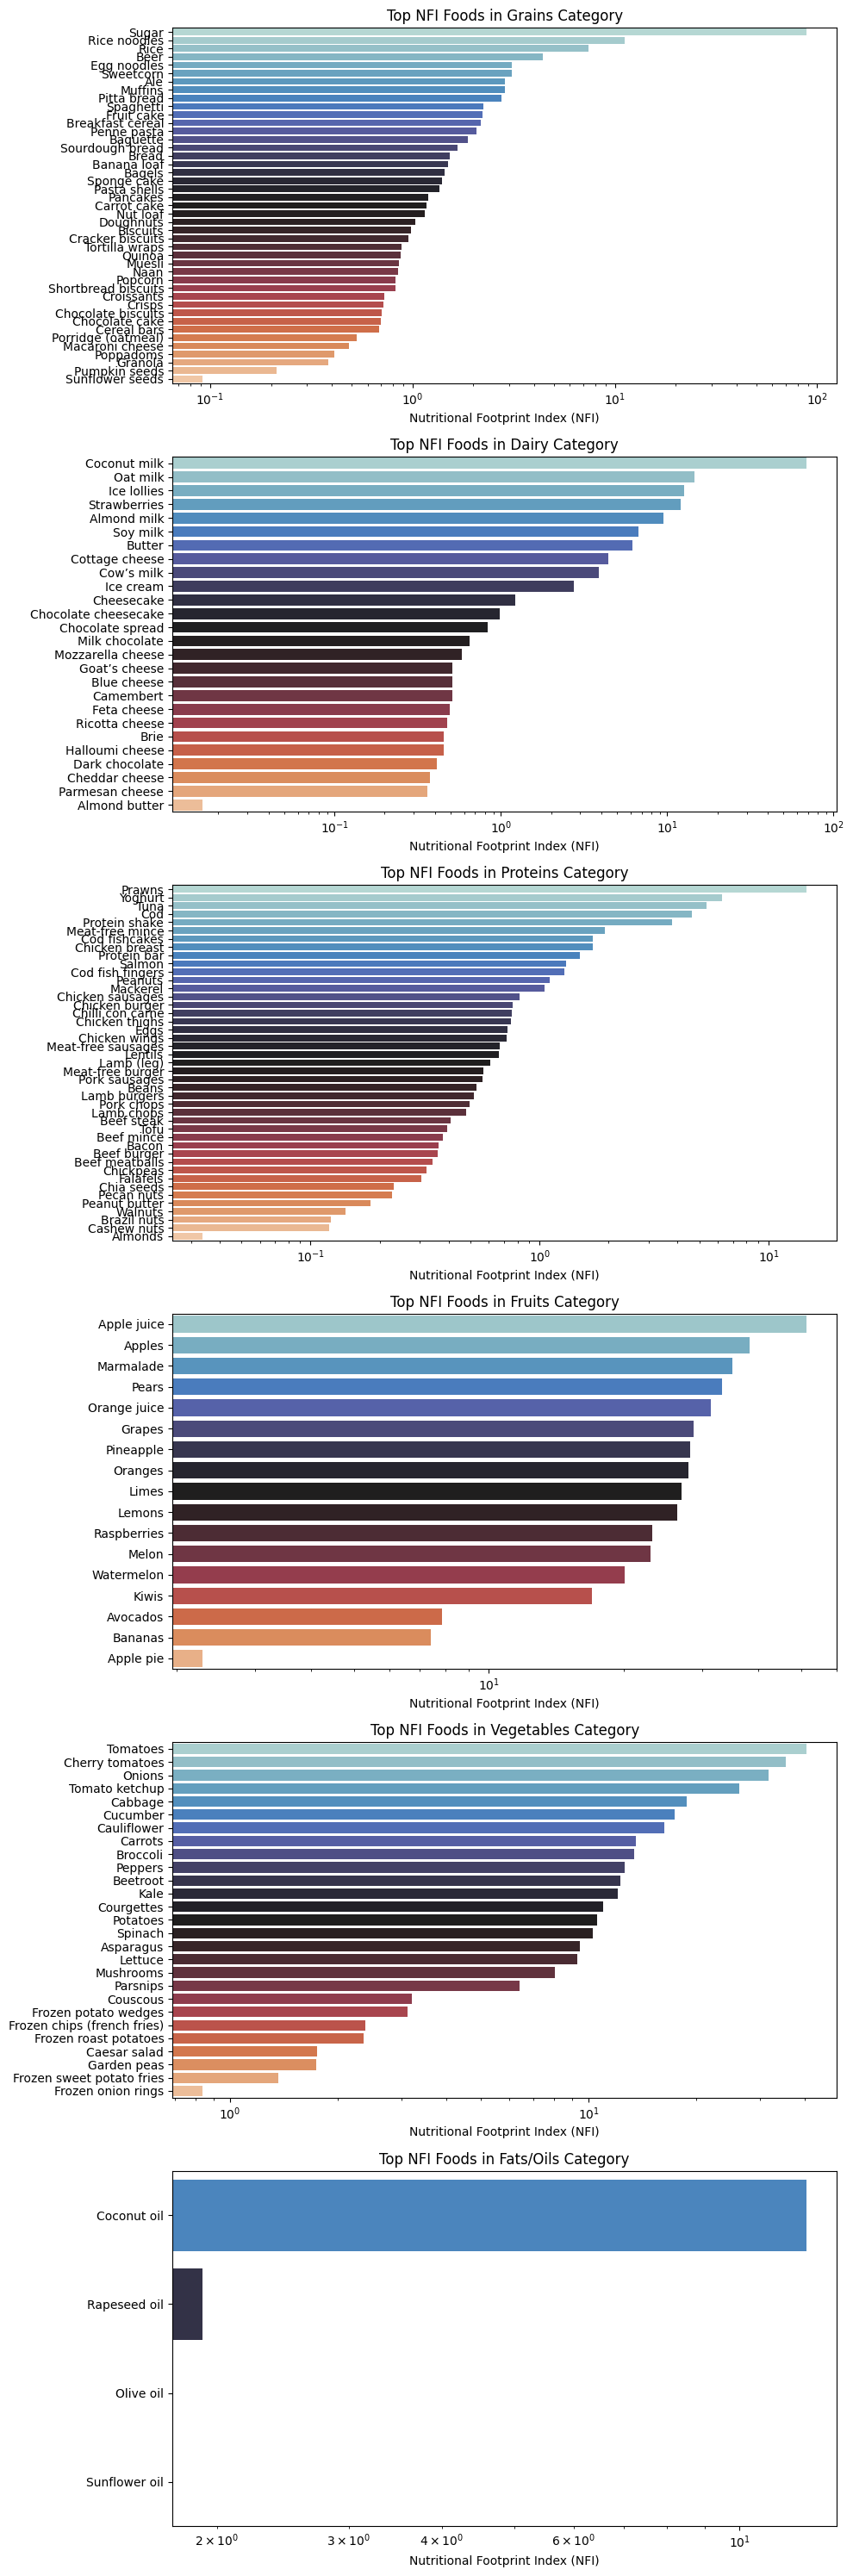

In [100]:
# Sort and display the top 50 (or fewer) items by NFI score within each food category
food_categories = df['Food Category'].unique()  # Extract unique food categories
# Define subplot rows and columns
n_rows = len(food_categories)

# Initialize the plot - adjust the figure size if necessary
plt.figure(figsize=(10, 5 * n_rows))
for i, category in enumerate(food_categories, 1):
    category_df = df[df['Food Category'] == category].sort_values(by='NFI', ascending=False).head(50)
    
    plt.subplot(n_rows, 1, i)
    
    sns.barplot(data=category_df, x='NFI', y='entity', palette='icefire')
    
    plt.title(f'Top NFI Foods in {category} Category')
    plt.xlabel('Nutritional Footprint Index (NFI)')
    plt.xscale('log')
    plt.ylabel('')
    plt.tight_layout()  # Adjust subplots to fit into the figure area

# Show plot
plt.show()